# Data Analysis of Lifestyle factors that influence Body Mass Index and its risk factors

## Motivation for the project
#### Chronic diseases are becoming major pandemic affecting both mortality as well as quality of life. The lifestyle factors (in addition to genetic factors) are major risk factors for chronic diseases. People do regular screening tests and track other measures but interpreting data in a meaningful way is scarce. The reason is that cause to effect in case of chronic diseases are complex and happens over long time. For example a single risk factor can influence multiple health parameters and a single health parameter can be influenced by multiple risk factors. A holisitic interdisciplinary approach (Medicine, Datascience and Artificial Intelligence, Computational and complex Science) is critical to provide people meaningful actions to tackle chronic diseases.
#### Pathological obesity is one of the major risk factor for many chronic diseases. The project aims to get quantitative details of various factors that influence the body mass index

## AIM of the project

#### To analyze lifestyle factors that influence Body Mass Index and its intermediary risk factors (fatty liver (steatosis), fibrotic liver, fat mass etc) using data analytic tools with rigorous scientific methods
#### To get quantitative details to build realistic computational models and personal preventive precision AI models 

#### DataSource: NHANES (National Health and Nutrition Examination Survey). https://www.cdc.gov/nchs/nhanes/about_nhanes.htm. 

# References
1) Slentz CA, Duscha BD, Johnson JL, Ketchum K, Aiken LB, Samsa GP, Houmard JA, Bales CW, Kraus WE. Effects of the amount of exercise on body weight, body composition, and measures of central obesity: STRRIDE--a randomized controlled study. Arch Intern Med. 2004 Jan 12;164(1):31-9. doi: 10.1001/archinte.164.1.31. PMID: 14718319.

2)Hughes VA, Frontera WR, Roubenoff R, Evans WJ, Singh MA. Longitudinal changes in body composition in older men and women: role of body weight change and physical activity. Am J Clin Nutr. 2002 Aug;76(2):473-81. doi: 10.1093/ajcn/76.2.473. PMID: 12145025.

3) Jackson AS, Janssen I, Sui X, Church TS, Blair SN. Longitudinal changes in body composition associated with healthy ageing: men, aged 20-96 years. Br J Nutr. 2012 Apr;107(7):1085-91. doi: 10.1017/S0007114511003886. Epub 2011 Aug 3. PMID: 21810289.

###### Thanks to the US government policies to enable regular tracking of health and lifestyle factors of people and making data available as open source. The data provided is applicable not only to US population but to global population in general.

In [1]:
import xport
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import weightstats as stests
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

#### Data Loading

In [2]:
file_loc = '../nhanes_data_files/'
df_PAQ_2017_2018 = pd.read_sas(file_loc +'PAQ_J_2017_2018.xpt')
df_DBQ_2017_2018 = pd.read_sas(file_loc +'DBQ_J_2017_2018.xpt')

df_demog_2017_2018 = pd.read_sas(file_loc + 'DEMO_J_2017_2018.xpt')
df_DXX_2017_2018 = pd.read_sas(file_loc +'DXX_J_2017_2018.xpt')
df_BMX_2017_2018 = pd.read_sas(file_loc +'BMX_J_2017_2018.xpt')
df_LUX_2017_2018 = pd.read_sas(file_loc + 'LUX_J_2017_2018.xpt')

df_I_2017_2018 = pd.read_sas(file_loc +'INS_J_2017_2018.xpt')

#### Selecting relevant datasets and merging them
##### Note: Since insulin dataset measurements are less two separate dataframes are created
##### Note:  Since insulin values have long tail, the log values provide better normal distribution.

In [3]:
dfage_2017_2018=df_demog_2017_2018[['SEQN','RIDAGEYR']].copy()
dfage_20_2017_2018=dfage_2017_2018[dfage_2017_2018['RIDAGEYR']>20].copy()
dfbmi=df_BMX_2017_2018[['SEQN','BMXWT','BMXBMI','BMXWAIST']].copy()

df_merge_paq_dbq=dfage_20_2017_2018.merge(dfbmi,on='SEQN')
df_merge_paq_dbq_I=df_merge_paq_dbq.merge(df_I_2017_2018[['SEQN','LBXIN']],on='SEQN')
df_merge_paq_dbq_I['loge_LBXIN']=np.log(df_merge_paq_dbq_I['LBXIN'])

df_merge_paq_dbq=df_merge_paq_dbq.merge(df_LUX_2017_2018[['SEQN','LUXSMED','LUXCAPM']],on='SEQN')
df_merge_paq_dbq=df_merge_paq_dbq.merge(df_DXX_2017_2018[['SEQN','DXDTRPF','DXDTOPF','DXDTOLI']],on='SEQN')

df_merge_paq_dbq=df_merge_paq_dbq.merge(df_PAQ_2017_2018,on='SEQN')
df_merge_paq_dbq=df_merge_paq_dbq.merge(df_DBQ_2017_2018,on='SEQN')
df_merge_paq_dbq_I=df_merge_paq_dbq_I.merge(df_PAQ_2017_2018,on='SEQN')
df_merge_paq_dbq_I=df_merge_paq_dbq_I.merge(df_DBQ_2017_2018,on='SEQN')

#Final Dataframes
df_merge_paq_dbq.shape,df_merge_paq_dbq_I.shape


((3175, 71), (2502, 68))

### Overall data description

In [4]:
#physical activity
#PAQ655 - Days vigorous recreational activities
#PAD660 - Minutes vigorous recreational activities
#PAD680 - Minutes sedentary activity

#Diet
#DBD895 - # of meals not home prepared
#DBQ700 - How healthy is the diet (HIgher values its poor)

#BMXBMI - body mass index
#BMXWAIST - Waist cricumference
#DXDTOLI - Lean body mass
#DXDTRPF - Trunk percent fat 
# DXDTOPF - Total body percent fat
# LUXSMED - smed values for fibrotic liverl assessment
# LUXCAPM - capm values for hepatic staeatosis (fatty liver) assessment 

df_merge_paq_dbq[['RIDAGEYR','BMXBMI','BMXWAIST','DXDTOLI','DXDTRPF','DXDTOPF','LUXSMED','LUXCAPM','PAQ655','PAD660','PAD680','DBD895','DBQ700']].describe()

,RIDAGEYR,BMXBMI,BMXWAIST,DXDTOLI,DXDTRPF,DXDTOPF,LUXSMED,LUXCAPM,PAQ655,PAD660,PAD680,DBD895,DBQ700
count,3175.000000,3140.000000,3017.000000,2202.000000,2351.000000,2202.000000,2968.000000,2967.000000,971.000000,968.000000,3167.000000,3.175000e+03,3175.000000
mean,40.414803,30.110510,99.617799,53430.545913,32.605827,33.584105,5.828032,262.758342,3.486097,72.729339,361.035049,2.608409e+01,3.133228
std,11.351250,7.852552,17.956221,13049.614331,8.685784,8.511506,5.175513,63.722737,3.463590,50.197202,604.495504,4.558422e+02,1.014179
min,21.000000,14.800000,57.900000,21324.700000,10.100000,12.100000,1.700000,100.000000,1.000000,10.000000,2.000000,5.397605e-79,1.000000
25%,31.000000,24.600000,86.600000,42866.475000,26.900000,27.325000,4.000000,215.000000,2.000000,40.000000,180.000000,1.000000e+00,3.000000
50%,40.000000,28.800000,97.500000,52056.650000,33.100000,33.500000,4.900000,261.000000,3.000000,60.000000,300.000000,3.000000e+00,3.000000
75%,51.000000,34.000000,110.200000,62266.450000,39.300000,40.600000,6.100000,306.000000,4.000000,90.000000,480.000000,5.000000e+00,4.000000
max,59.000000,86.200000,169.500000,108410.700000,56.400000,56.100000,75.000000,400.000000,99.000000,480.000000,9999.000000,9.999000e+03,9.000000


In [5]:
# df_merge_paq_dbq[df_merge_paq_dbq['PAD660']<200]['PAD660'].hist(bins=100)
# df_merge_paq_dbq['PAD660'].hist(bins=100)

#### Correlation Analysis

In [6]:
df_merge_paq_dbq[['BMXBMI','BMXWAIST','DXDTOLI','DXDTRPF','DXDTOPF','LUXSMED','LUXCAPM','PAQ655','PAD660','PAD680','DBD895','DBQ700']].corr()

,BMXBMI,BMXWAIST,DXDTOLI,DXDTRPF,DXDTOPF,LUXSMED,LUXCAPM,PAQ655,PAD660,PAD680,DBD895,DBQ700
BMXBMI,1.000000,0.922032,0.590514,0.648821,0.574562,0.315358,0.557092,-0.051934,0.006572,0.037365,-0.012376,0.258495
BMXWAIST,0.922032,1.000000,0.654738,0.620683,0.504889,0.304943,0.621077,-0.100340,-0.022575,0.037633,-0.020114,0.258075
DXDTOLI,0.590514,0.654738,1.000000,-0.093611,-0.218424,0.196366,0.398651,-0.017465,0.145283,0.008319,0.020844,0.146189
DXDTRPF,0.648821,0.620683,-0.093611,1.000000,0.953194,0.123633,0.421996,-0.099048,-0.184775,0.058961,-0.041469,0.191127
DXDTOPF,0.574562,0.504889,-0.218424,0.953194,1.000000,0.082020,0.292859,-0.090814,-0.186635,0.045196,-0.045538,0.169893
LUXSMED,0.315358,0.304943,0.196366,0.123633,0.082020,1.000000,0.262383,-0.045329,0.000519,0.016474,-0.002698,0.085970
LUXCAPM,0.557092,0.621077,0.398651,0.421996,0.292859,0.262383,1.000000,-0.056877,-0.027610,0.018916,-0.023048,0.168744
PAQ655,-0.051934,-0.100340,-0.017465,-0.099048,-0.090814,-0.045329,-0.056877,1.000000,0.067699,-0.052833,-0.005331,-0.088624
PAD660,0.006572,-0.022575,0.145283,-0.184775,-0.186635,0.000519,-0.027610,0.067699,1.000000,-0.093959,-0.025995,0.075925
PAD680,0.037365,0.037633,0.008319,0.058961,0.045196,0.016474,0.018916,-0.052833,-0.093959,1.000000,0.212382,0.012412


In [7]:
#### Graphical plots

Text(0, 0.5, 'Trunk percent Fat')

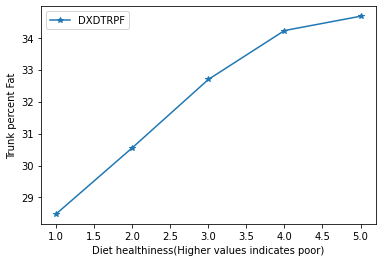

In [8]:
df_merge_paq_dbq[['DBQ700','DXDTRPF']].groupby(df_merge_paq_dbq['DBQ700']).mean().plot(marker='*',x='DBQ700',y='DXDTRPF')
plt.xlabel('Diet healthiness(Higher values indicates poor)')
plt.ylabel('Trunk percent Fat')
#

#### Linear Regression model Analysis

In [9]:
### Research Question: Is there an association between Trunk Fat percentage and healthiness of diet?
# Testing done using Ordinary Least Square (OLS) regression. Dependant variable: Trunk Fat percentage
###     Null hypothesis (H0): There is NO association;
###     Alternative hypothesis (H1): There is an association.


In [10]:
model = smf.ols(formula="DXDTRPF ~ DBQ700", data=df_merge_paq_dbq).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                DXDTRPF   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     89.06
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           8.88e-21
Time:                        08:05:22   Log-Likelihood:                -8373.8
No. Observations:                2351   AIC:                         1.675e+04
Df Residuals:                    2349   BIC:                         1.676e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.4323      0.576     47.648      0.0

In [11]:
### R-squared = 0.041, meaning 4% of the outcome variability is explained by the model.
### t-ratio (for a t-distribution) of 10.576 (fourth column) which gives a p-value <0.001 (fifth column),
### 95% confidence interval for the beta coefficient between 1.475(lower bound, sixth column) and 2.147 (upper bound, seventh column

### We can reject the null hypothesis. There is a positive (beta coefficient>1.0) association, which is statistically significant (p<0.01 and 95% CI does not include a coefficient=0.0) 

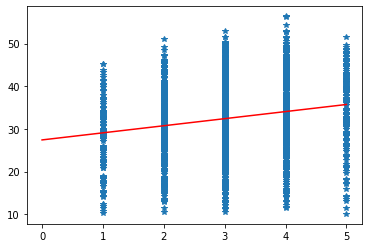

In [12]:
x=[i for i in range(0,6)]

y=[model.params[0]+i*model.params[1] for i in x]

plt.plot(df_merge_paq_dbq['DBQ700'],df_merge_paq_dbq['DXDTRPF'],'*')
plt.plot(x,y,'r')

In [13]:
### Research Question: Is there an association between Trunk Fat percentage and amount of time spent on vigorous recreational activities?

Text(0, 0.5, 'Trunk percent Fat')

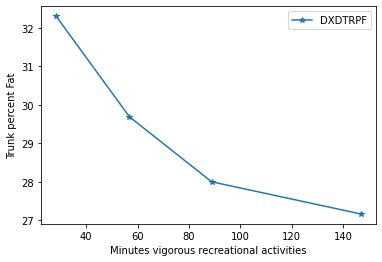

In [14]:
df_merge_paq_dbq[['PAD660','DXDTRPF']].groupby(pd.cut(df_merge_paq_dbq['PAD660'], [df_merge_paq_dbq['PAD660'].min(),df_merge_paq_dbq['PAD660'].describe()['25%'], df_merge_paq_dbq['PAD660'].describe()['50%'],df_merge_paq_dbq['PAD660'].describe()['75%'],df_merge_paq_dbq['PAD660'].max()])).mean().plot(marker='*',x='PAD660',y='DXDTRPF')
plt.xlabel('Minutes vigorous recreational activities')
plt.ylabel('Trunk percent Fat')

In [15]:
model = smf.ols(formula="DXDTRPF ~ PAD660", data=df_merge_paq_dbq).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                DXDTRPF   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     27.68
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           1.85e-07
Time:                        08:05:25   Log-Likelihood:                -2785.9
No. Observations:                 785   AIC:                             5576.
Df Residuals:                     783   BIC:                             5585.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.9062      0.526     60.622      0.0

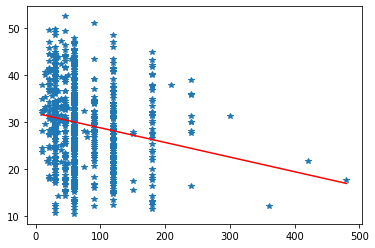

In [16]:
x=[i for i in range(10,481)]

y=[model.params[0]+i*model.params[1] for i in x]

plt.plot(df_merge_paq_dbq['PAD660'],df_merge_paq_dbq['DXDTRPF'],'*')
plt.plot(x,y,'r')

In [17]:
### Research Question: Is there an association between Trunk Fat percentage and the healthiness of diet plus amount of time spent on vigorous recreational activities?
### Multilinear regression Analysis

In [18]:
model = smf.ols(formula="DXDTRPF ~ PAD660+DBQ700", data=df_merge_paq_dbq).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                DXDTRPF   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     30.69
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           1.48e-13
Time:                        08:05:27   Log-Likelihood:                -2769.8
No. Observations:                 785   AIC:                             5546.
Df Residuals:                     782   BIC:                             5560.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.0206      0.999     27.035      0.0

In [19]:
df_merge_paq_dbq_I[['BMXBMI','BMXWAIST','LBXIN','loge_LBXIN','PAD660','PAD680','PAQ655','DBD895','DBQ700']].describe()

,BMXBMI,BMXWAIST,LBXIN,loge_LBXIN,PAD660,PAD680,PAQ655,DBD895,DBQ700
count,2455.000000,2353.000000,2352.000000,2352.000000,565.000000,2.498000e+03,566.000000,2.502000e+03,2502.000000
mean,29.848065,100.706672,14.708406,2.335207,88.959292,3.806209e+02,3.402827,2.529616e+01,3.057154
std,7.438616,16.923761,21.165400,0.772702,420.742185,7.235781e+02,1.554984,4.600016e+02,1.013469
min,14.900000,63.200000,0.710000,-0.342490,10.000000,5.397605e-79,1.000000,5.397605e-79,1.000000
25%,24.700000,88.400000,6.237500,1.830579,40.000000,1.800000e+02,2.000000,1.000000e+00,2.000000
50%,28.500000,99.200000,9.955000,2.298075,60.000000,3.000000e+02,3.000000,2.000000e+00,3.000000
75%,33.600000,111.300000,16.405000,2.797586,90.000000,4.800000e+02,4.000000,4.000000e+00,4.000000
max,86.200000,169.500000,485.100000,6.184355,9999.000000,9.999000e+03,7.000000,9.999000e+03,5.000000


In [20]:
df_merge_paq_dbq_I[['BMXBMI','BMXWAIST','LBXIN','loge_LBXIN','PAQ655','PAD660','PAD680','DBD895','DBQ700']].corr()

,BMXBMI,BMXWAIST,LBXIN,loge_LBXIN,PAQ655,PAD660,PAD680,DBD895,DBQ700
BMXBMI,1.000000,0.903447,0.305328,0.545119,-0.081733,-0.027775,0.024277,-0.006525,0.227851
BMXWAIST,0.903447,1.000000,0.310940,0.561232,-0.105622,-0.019130,0.036838,-0.022677,0.209447
LBXIN,0.305328,0.310940,1.000000,0.711160,-0.115817,-0.004591,0.049172,-0.014067,0.101363
loge_LBXIN,0.545119,0.561232,0.711160,1.000000,-0.145211,0.012615,0.036482,-0.015960,0.179484
PAQ655,-0.081733,-0.105622,-0.115817,-0.145211,1.000000,0.099000,-0.037666,-0.011553,-0.218666
PAD660,-0.027775,-0.019130,-0.004591,0.012615,0.099000,1.000000,-0.011007,-0.006185,0.022668
PAD680,0.024277,0.036838,0.049172,0.036482,-0.037666,-0.011007,1.000000,0.226232,0.050207
DBD895,-0.006525,-0.022677,-0.014067,-0.015960,-0.011553,-0.006185,0.226232,1.000000,0.045905
DBQ700,0.227851,0.209447,0.101363,0.179484,-0.218666,0.022668,0.050207,0.045905,1.000000


<AxesSubplot:xlabel='DBQ700'>

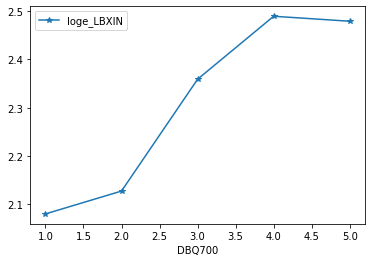

In [21]:
df_merge_paq_dbq_I[['DBQ700','loge_LBXIN']].groupby(df_merge_paq_dbq_I['DBQ700']).mean().plot(marker='*',x='DBQ700',y='loge_LBXIN')

<AxesSubplot:xlabel='DBQ700'>

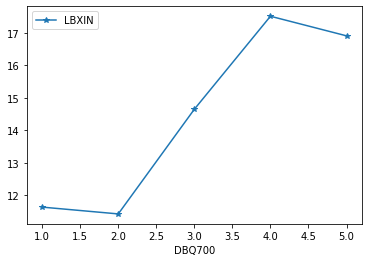

In [22]:
df_merge_paq_dbq_I[['DBQ700','LBXIN']].groupby(df_merge_paq_dbq_I['DBQ700']).mean().plot(marker='*',x='DBQ700',y='LBXIN')

In [23]:
model = smf.ols(formula="loge_LBXIN ~ DBQ700", data=df_merge_paq_dbq_I).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             loge_LBXIN   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     78.22
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           1.77e-18
Time:                        08:05:30   Log-Likelihood:                -2691.8
No. Observations:                2352   AIC:                             5388.
Df Residuals:                    2350   BIC:                             5399.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9163      0.050     38.413      0.0

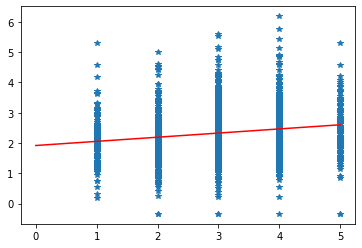

In [24]:
x=[i for i in range(0,6)]

y=[model.params[0]+i*model.params[1] for i in x]

plt.plot(df_merge_paq_dbq_I['DBQ700'],df_merge_paq_dbq_I['loge_LBXIN'],'*')
plt.plot(x,y,'r')

In [25]:
print(df_merge_paq_dbq_I[['PAQ655','loge_LBXIN','LBXIN']].dropna().shape)
df_merge_paq_dbq_I[['PAQ655','loge_LBXIN','LBXIN']].dropna().corr()

(532, 3)


,PAQ655,loge_LBXIN,LBXIN
PAQ655,1.000000,-0.145211,-0.115817
loge_LBXIN,-0.145211,1.000000,0.834166
LBXIN,-0.115817,0.834166,1.000000


<AxesSubplot:xlabel='PAQ655'>

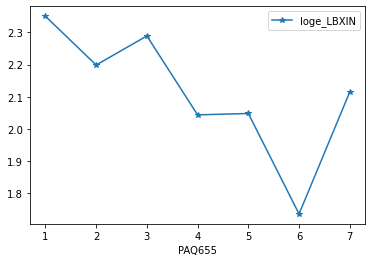

In [26]:
df_merge_paq_dbq_I[['PAQ655','loge_LBXIN']].groupby(df_merge_paq_dbq_I['PAQ655']).mean().plot(marker='*',x='PAQ655',y='loge_LBXIN')

<AxesSubplot:xlabel='PAQ655'>

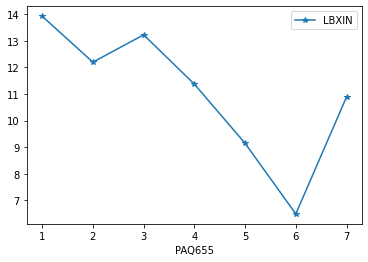

In [27]:
df_merge_paq_dbq_I[['PAQ655','LBXIN']].groupby(df_merge_paq_dbq_I['PAQ655']).mean().plot(marker='*',x='PAQ655',y='LBXIN')

In [28]:
model = smf.ols(formula="loge_LBXIN ~ PAQ655", data=df_merge_paq_dbq_I).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             loge_LBXIN   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     11.42
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           0.000782
Time:                        08:05:35   Log-Likelihood:                -584.17
No. Observations:                 532   AIC:                             1172.
Df Residuals:                     530   BIC:                             1181.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4025      0.076     31.684      0.0

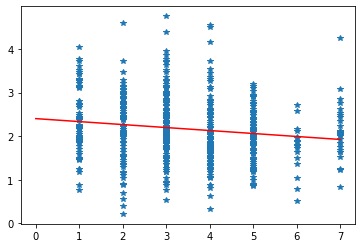

In [29]:
x=[i for i in range(0,8)]

y=[model.params[0]+i*model.params[1] for i in x]

plt.plot(df_merge_paq_dbq_I['PAQ655'],df_merge_paq_dbq_I['loge_LBXIN'],'*')
plt.plot(x,y,'r')

In [30]:
model = smf.ols(formula="loge_LBXIN ~ PAQ655 + DBQ700", data=df_merge_paq_dbq_I).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             loge_LBXIN   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     22.62
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           3.76e-10
Time:                        08:05:37   Log-Likelihood:                -568.02
No. Observations:                 532   AIC:                             1142.
Df Residuals:                     529   BIC:                             1155.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8002      0.128     14.069      0.0

In [31]:
print(df_merge_paq_dbq_I[['PAD660','loge_LBXIN','LBXIN']].dropna().shape)
df_merge_paq_dbq_I[['PAD660','loge_LBXIN','LBXIN']].dropna().corr()

(531, 3)


,PAD660,loge_LBXIN,LBXIN
PAD660,1.000000,0.012615,-0.004591
loge_LBXIN,0.012615,1.000000,0.834073
LBXIN,-0.004591,0.834073,1.000000


<AxesSubplot:xlabel='PAD660'>

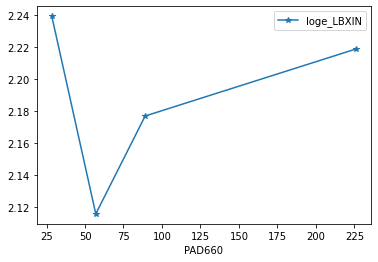

In [32]:
df_merge_paq_dbq_I[['PAD660','loge_LBXIN']].groupby(pd.cut(df_merge_paq_dbq_I['PAD660'], [df_merge_paq_dbq_I['PAD660'].min(),df_merge_paq_dbq_I['PAD660'].describe()['25%'], df_merge_paq_dbq_I['PAD660'].describe()['50%'],df_merge_paq_dbq_I['PAD660'].describe()['75%'],df_merge_paq_dbq_I['PAD660'].max()])).mean().plot(marker='*',x='PAD660',y='loge_LBXIN')

<AxesSubplot:xlabel='PAD660'>

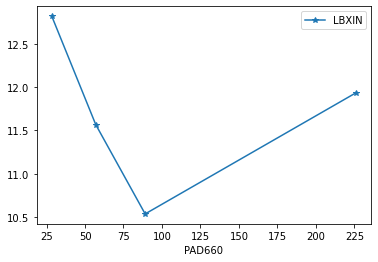

In [33]:
df_merge_paq_dbq_I[['PAD660','LBXIN']].groupby(pd.cut(df_merge_paq_dbq_I['PAD660'], [df_merge_paq_dbq_I['PAD660'].min(),df_merge_paq_dbq_I['PAD660'].describe()['25%'], df_merge_paq_dbq_I['PAD660'].describe()['50%'],df_merge_paq_dbq_I['PAD660'].describe()['75%'],df_merge_paq_dbq_I['PAD660'].max()])).mean().plot(marker='*',x='PAD660',y='LBXIN')

In [34]:
model = smf.ols(formula="loge_LBXIN ~PAD660 ", data=df_merge_paq_dbq_I).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             loge_LBXIN   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.08420
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.772
Time:                        08:05:41   Log-Likelihood:                -588.77
No. Observations:                 531   AIC:                             1182.
Df Residuals:                     529   BIC:                             1190.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1688      0.033     66.613      0.0

In [35]:

model = smf.ols(formula="DXDTRPF ~ PAQ655+PAD660+PAD680+DBD895+DBQ700", data=df_merge_paq_dbq).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                DXDTRPF   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     14.26
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           2.27e-13
Time:                        08:05:42   Log-Likelihood:                -2765.1
No. Observations:                 785   AIC:                             5542.
Df Residuals:                     779   BIC:                             5570.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.7281      1.385     19.304      0.0

In [36]:
model = smf.ols(formula="loge_LBXIN ~ PAQ655+PAD660+PAD680+DBD895+DBQ700", data=df_merge_paq_dbq_I).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             loge_LBXIN   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     9.560
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           9.63e-09
Time:                        08:05:42   Log-Likelihood:                -565.68
No. Observations:                 531   AIC:                             1143.
Df Residuals:                     525   BIC:                             1169.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7691      0.130     13.636      0.0

In [37]:
dataset_ai=df_merge_paq_dbq[['PAQ655','PAD660','PAD680','DBD895','DBQ700','DXDTRPF']].dropna()
X = dataset_ai[['PAQ655','PAD660','PAD680','DBD895','DBQ700']]
y = dataset_ai['DXDTRPF']
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.2, random_state=1)
train_X.shape,val_X.shape

((628, 5), (157, 5))

In [38]:
# create regressor object 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0) 
  
# fit the regressor with x and y data 
my_model =regressor.fit(train_X, train_y)

In [39]:
y_pred = my_model.predict(val_X)

from sklearn.metrics import r2_score
rsquare = r2_score(val_y, y_pred) #can be negative as the AI model are not linear regressors 
rsquare

0.008247339666505593

In [40]:
#Conclusions
#Further work that were done - Indepth Analysis (Specific food type)